### Import Libraries

In [1]:
import os
import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Samlpe Raw Data

In [2]:
train_face_dir = './data/face'
train_mask_dir = './data/mask'
face_fnames = os.listdir(train_face_dir)
mask_fnames = os.listdir(train_mask_dir)

print("Total face images:", len(os.listdir(train_face_dir)))
print("Total mask images:", len(os.listdir(train_mask_dir)))

Total face images: 2203
Total mask images: 2203


In [3]:
nrows , ncols = 4,4
pic_index = 0 
random.shuffle(face_fnames)
random.shuffle(mask_fnames)

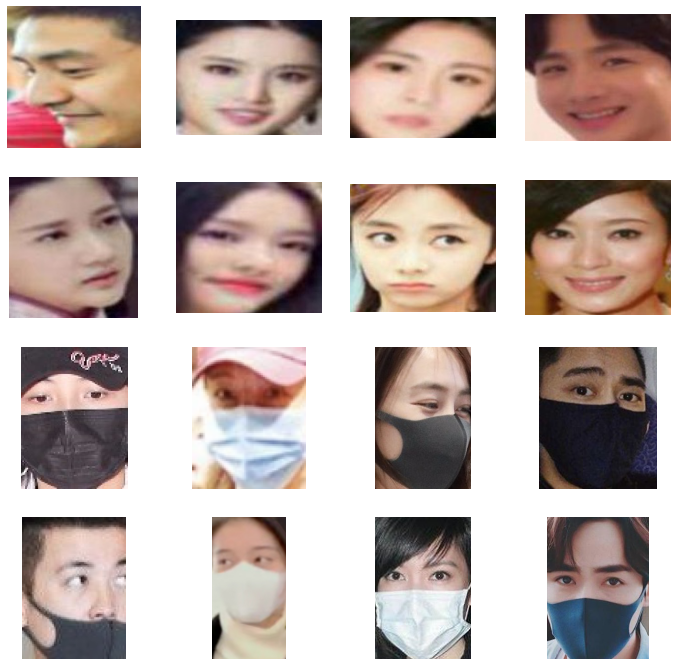

In [4]:
# Run this cell, each time show 8 positive and 8 negative samples
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows *3)
pic_index+=8

next_cat_pix = [os.path.join(train_face_dir,f) for f in face_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_mask_dir,f) for f in mask_fnames[pic_index-8:pic_index]]

for i,img_path in enumerate(next_cat_pix +  next_dog_pix):
    sp = plt.subplot(ncols,nrows,i+1)
    sp.axis("Off")
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

### Generate Training and Validation Batches
- Split train and validation as 0.8 to 0.2

In [5]:
train_data_dir = './data'
batch_size = 32
img_size = (150,150)
nb_epochs = 20

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  rotation_range=20,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = img_size,
                                                   batch_size = batch_size,
                                                   class_mode = "binary",
                                                   subset = 'training')

validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size = img_size,
                                                   batch_size = batch_size,
                                                   class_mode = "binary",
                                                       subset = "validation")

Found 3526 images belonging to 2 classes.
Found 880 images belonging to 2 classes.


### Create CNN Model
- Using existing model with pretrained weight
- Resize images to 150x150 

In [6]:
# use pre-trained model
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False)
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation = "sigmoid")(x)

model = Model(pre_trained_model.input,x)
model.compile(optimizer = RMSprop(lr= 0.0001),
             loss = "binary_crossentropy",
             metrics = ["accuracy"])

### Train, Save and Evaluate Model

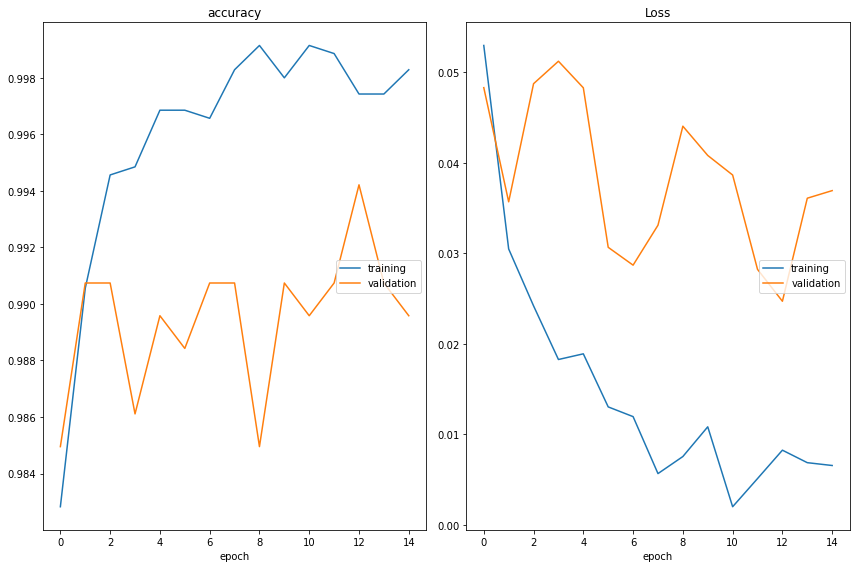

accuracy
	training         	 (min:    0.983, max:    0.999, cur:    0.998)
	validation       	 (min:    0.985, max:    0.994, cur:    0.990)
Loss
	training         	 (min:    0.002, max:    0.053, cur:    0.007)
	validation       	 (min:    0.025, max:    0.051, cur:    0.037)

Epoch 00015: val_accuracy did not improve from 0.99421
110/110 [==============================] - 62s 566ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0369 - val_accuracy: 0.9896
Wall time: 15min 39s


In [7]:
%%time

epochs = 15 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("./models/mask_detect_model.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks = callbacks,
    epochs = epochs)